In [ ]:
pip install fredapi

✔️ 최적 ARIMA order: (1, 0, 1)
✔️ 최적 Seasonal order: (1, 1, 1, 12)
✔️ 최적 AIC: 86.69350204976047


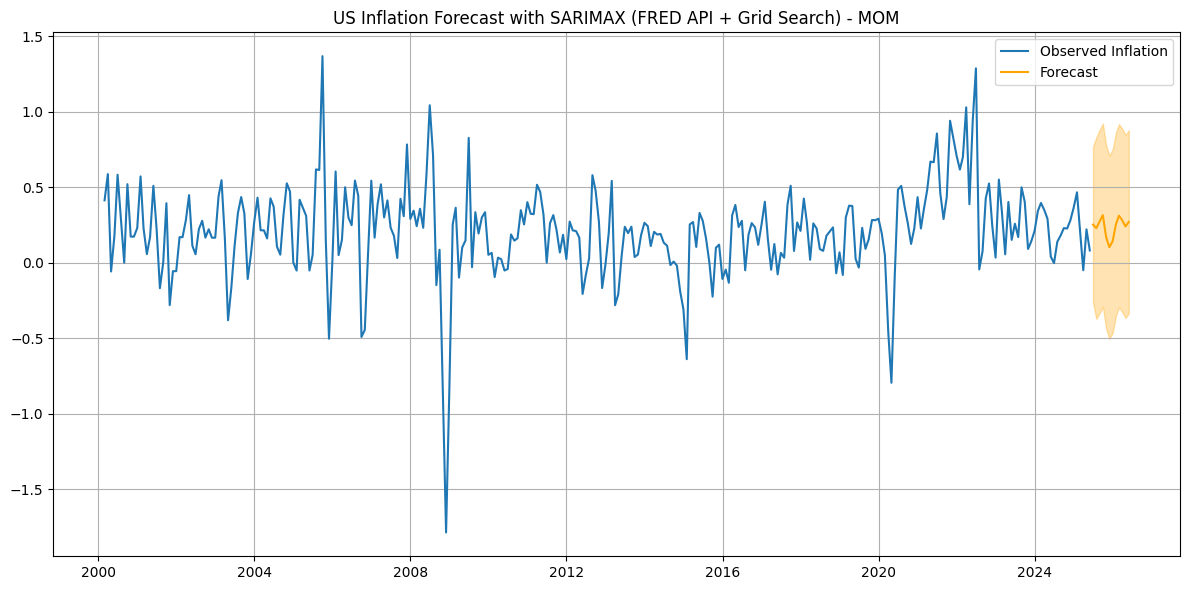

In [ ]:
# ▶ 설치가 필요한 패키지 (처음 한 번만)
# pip install fredapi statsmodels matplotlib pandas

from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from itertools import product
import warnings
warnings.filterwarnings("ignore")

# 1. FRED API 설정
fred = Fred(api_key='YOUR API KEY')

# 2. 데이터 수집
start, end = '2000-01-01', '2025-05-31'
cpi = fred.get_series('CPIAUCSL', observation_start=start, observation_end=end)
rate = fred.get_series('DGS10', observation_start=start, observation_end=end)
unemp = fred.get_series('UNRATE', observation_start=start, observation_end=end)

# 3. 데이터 전처리
data = pd.concat([cpi, rate, unemp], axis=1)
data.columns = ['CPI', 'InterestRate', 'Unemployment']
data.index = pd.to_datetime(data.index)
data = data.resample('M').mean().interpolate()

# 4. 로그 인플레이션율 계산
data['Inflation'] = np.log(data['CPI']).diff() * 100
data.dropna(inplace=True)
exog = data[['InterestRate', 'Unemployment']]

# 5. ADF 검정 → 차분 차수 결정
d = 0 if adfuller(data['Inflation'])[1] < 0.05 else 1

# 6. SARIMAX 모수 자동 최적화 (Grid Search)
p = q = P = Q = [0, 1]
D, s = 1, 12
best_aic = np.inf
best_order = best_seasonal = None

for param in product(p, q, P, Q):
    try:
        model = SARIMAX(data['Inflation'],
                        exog=exog,
                        order=(param[0], d, param[1]),
                        seasonal_order=(param[2], D, param[3], s),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        res = model.fit(disp=False)
        if res.aic < best_aic:
            best_aic = res.aic
            best_order = (param[0], d, param[1])
            best_seasonal = (param[2], D, param[3], s)
    except:
        continue

print("✔️ 최적 ARIMA order:", best_order)
print("✔️ 최적 Seasonal order:", best_seasonal)
print("✔️ 최적 AIC:", best_aic)

# 7. 최종 모델 적합
final_model = SARIMAX(data['Inflation'],
                      exog=exog,
                      order=best_order,
                      seasonal_order=best_seasonal,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
final_result = final_model.fit()

# 8. 향후 예측 (exog는 단순 반복 또는 시나리오 설정)
forecast_steps = 12
future_exog = exog.iloc[-12:]
forecast = final_result.get_forecast(steps=forecast_steps, exog=future_exog)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# 9. 시각화
plt.figure(figsize=(12, 6))
plt.plot(data['Inflation'], label='Observed Inflation')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='orange')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.3)
plt.title("US Inflation Forecast with SARIMAX (FRED API + Grid Search) - MOM")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 11.1 MB/s eta 0:00:00


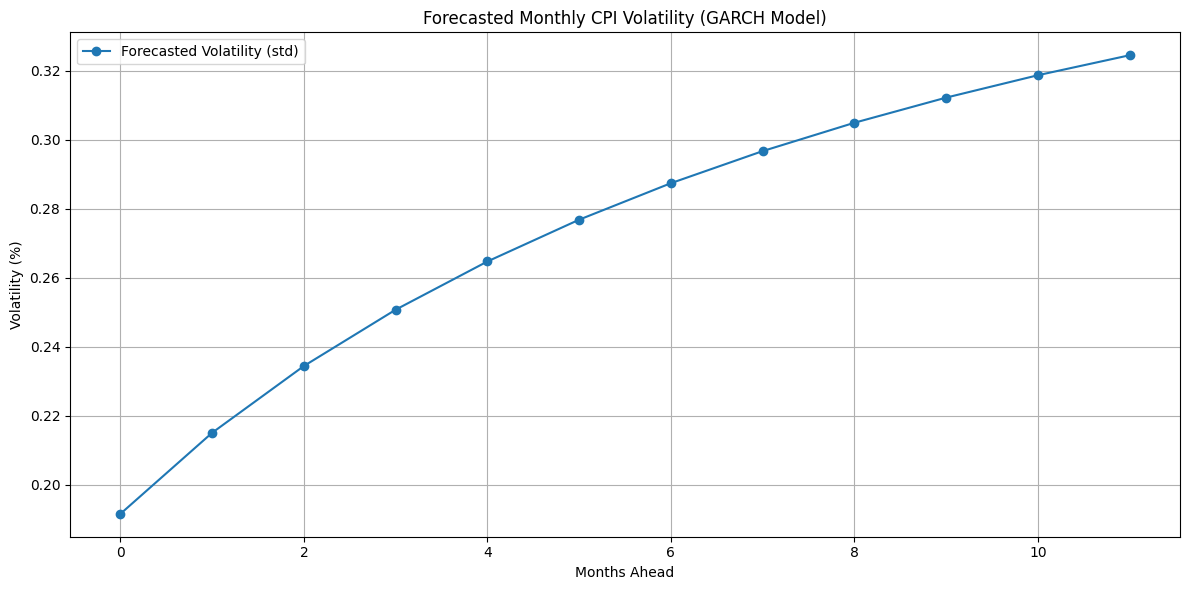

array([0.19163941, 0.21512273, 0.23445888, 0.25076369, 0.26473095,
       0.27683042, 0.28739947, 0.29669108, 0.30490115, 0.31218534,
       0.31866984, 0.32445862])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# 기존 인플레이션 데이터 불러오기
# (Inflation, exog는 이미 전 단계에서 정의됨)
inflation = data['Inflation']

# 1. GARCH(1,1) 모델 적합 (잔차가 아니라 인플레이션 수익률 자체에 모델링)
garch_model = arch_model(inflation, vol='GARCH', p=1, q=1, rescale=False)
garch_result = garch_model.fit(disp='off')

# 2. 향후 12개월에 대한 조건부 분산 예측
garch_forecast = garch_result.forecast(horizon=12)
vol_forecast = np.sqrt(garch_forecast.variance.values[-1, :])  # 표준편차 (volatility)

# 3. 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(vol_forecast, marker='o', label='Forecasted Volatility (std)')
plt.title('Forecasted Monthly CPI Volatility (GARCH Model)')
plt.xlabel('Months Ahead')
plt.ylabel('Volatility (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 최종 GARCH 예측값 반환
vol_forecast


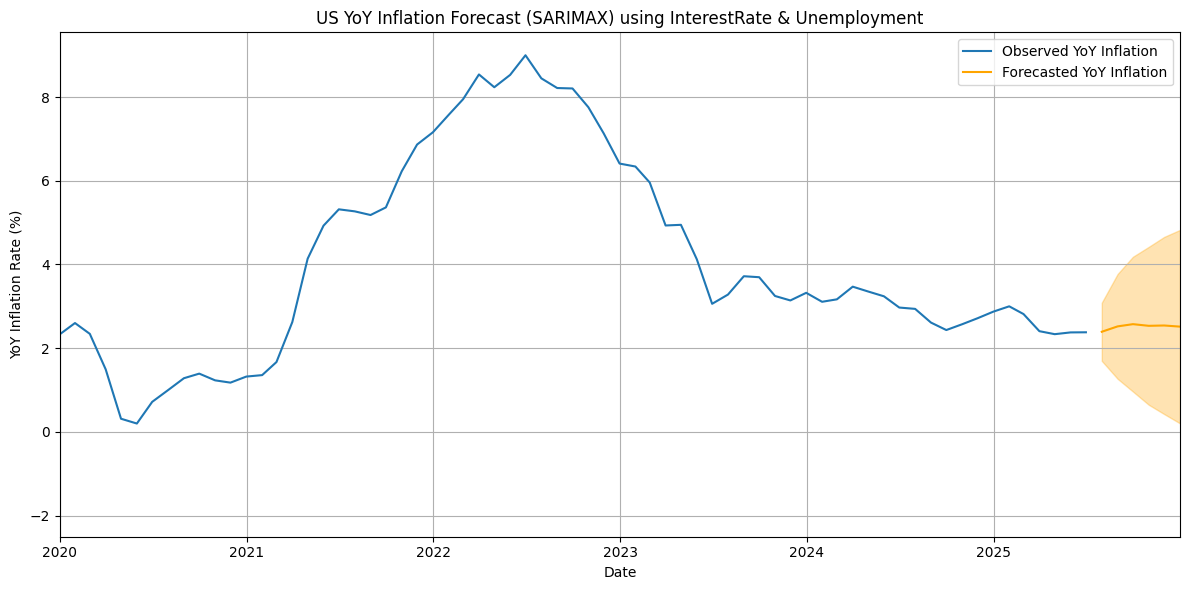

최적 SARIMAX 모수: (1, 0, 1) (1, 1, 1, 12)
최적 AIC 값: 235.01058447577637


In [ ]:
# 1. YoY 인플레이션율 계산
data['YoY_Inflation'] = (data['CPI'] / data['CPI'].shift(12) - 1) * 100
data.dropna(inplace=True)

# 2. ADF 검정: 정상성 확인
from statsmodels.tsa.stattools import adfuller
adf_pvalue = adfuller(data['YoY_Inflation'])[1]
d_yoy = 0 if adf_pvalue < 0.05 else 1

# 3. exog 설정
exog_yoy = data[['InterestRate', 'Unemployment']]

# 4. SARIMAX 모수 범위 지정 (Grid Search)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import numpy as np

p = q = P = Q = [0, 1]
D, s = 1, 12
parameters = list(product(p, q, P, Q))
best_aic = np.inf
best_order = None
best_seasonal = None

for param in parameters:
    try:
        model = SARIMAX(data['YoY_Inflation'],
                        exog=exog_yoy,
                        order=(param[0], d_yoy, param[1]),
                        seasonal_order=(param[2], D, param[3], s),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        result = model.fit(disp=False)
        if result.aic < best_aic:
            best_aic = result.aic
            best_order = (param[0], d_yoy, param[1])
            best_seasonal = (param[2], D, param[3], s)
    except:
        continue

# 5. 최종 모델 적합
final_model_yoy = SARIMAX(data['YoY_Inflation'],
                          exog=exog_yoy,
                          order=best_order,
                          seasonal_order=best_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
final_result_yoy = final_model_yoy.fit()

# 6. 향후 6개월 예측
forecast_steps = 6
future_exog = exog_yoy.iloc[-forecast_steps:]
forecast_yoy = final_result_yoy.get_forecast(steps=forecast_steps, exog=future_exog)
forecast_mean_yoy = forecast_yoy.predicted_mean
forecast_ci_yoy = forecast_yoy.conf_int()

# 7. 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['YoY_Inflation'], label='Observed YoY Inflation')
plt.plot(forecast_mean_yoy.index, forecast_mean_yoy, label='Forecasted YoY Inflation', color='orange')
plt.fill_between(forecast_ci_yoy.index,
                 forecast_ci_yoy.iloc[:, 0],
                 forecast_ci_yoy.iloc[:, 1],
                 color='orange', alpha=0.3)

# x축 범위 지정: 2020년부터 예측 끝까지
plt.xlim(pd.to_datetime('2020-01-01'), forecast_mean_yoy.index[-1])

plt.title('US YoY Inflation Forecast (SARIMAX) using InterestRate & Unemployment')
plt.xlabel('Date')
plt.ylabel('YoY Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("최적 SARIMAX 모수:", best_order, best_seasonal)
print("최적 AIC 값:", best_aic)

# 유가 & 소비자 신뢰지수로 외생변수 추가해서 비교하기

baseline   → ARIMA (1, 0, 1), seasonal (1, 1, 1, 12), AIC = 238.99
with_oil   → ARIMA (1, 0, 1), seasonal (0, 1, 1, 12), AIC = 273.08
with_conf  → ARIMA (1, 0, 1), seasonal (1, 1, 1, 12), AIC = 239.53
all        → ARIMA (1, 0, 1), seasonal (1, 1, 1, 12), AIC = 221.39
Best model: all


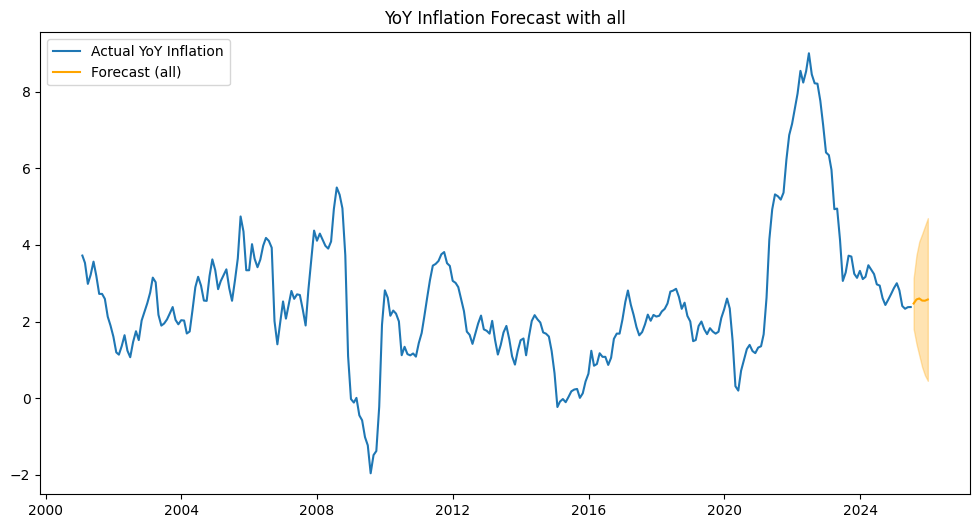

In [ ]:

# 데이터 수집 (2000년 이후 월간)
codes = {
    'CPI':'CPIAUCSL', 'InterestRate':'DGS10',
    'Unemployment':'UNRATE', 'Oil':'MCOILWTICO',
    'Conf':'UMCSENT'
}
data = pd.concat([fred.get_series(code, observation_start='2000-01-01')
                  for code in codes.values()], axis=1)
data.columns = list(codes.keys())
data.index = pd.to_datetime(data.index)
data = data.resample('M').mean().interpolate()

# YoY 인플레이션율 계산
data['YoY'] = (data['CPI']/data['CPI'].shift(12)-1)*100
data.dropna(inplace=True)

# 정상성 검사
d = 0 if adfuller(data['YoY'])[1] < 0.05 else 1

# 외생변수 세트
exogs = {
    'baseline': data[['InterestRate', 'Unemployment']],
    'with_oil': data[['InterestRate', 'Unemployment', 'Oil',]],
    'with_conf': data[['InterestRate', 'Unemployment', 'Conf']],
    'all': data[['InterestRate', 'Unemployment', 'Oil', 'Conf']]
}

def fit_sarimax(y, exog):
    best = (None, None, np.inf)
    for p,q,P,Q in product([0,1],[0,1],[0,1],[0,1]):
        try:
            res = SARIMAX(y, exog=exog, order=(p,d,q),
                          seasonal_order=(P,1,Q,12),
                          enforce_stationarity=False,
                          enforce_invertibility=False).fit(disp=False)
            if res.aic < best[2]:
                best = ((p,d,q),(P,1,Q,12),res.aic, res)
        except:
            continue
    return best  # (order, seasonal_order, aic, result)

results = {name: fit_sarimax(data['YoY'], exog) for name, exog in exogs.items()}

for name, (order, seasonal, aic, _) in results.items():
    print(f"{name:<10} → ARIMA {order}, seasonal {seasonal}, AIC = {aic:.2f}")

best_name, (ordr, seas, aic, model_res) = min(results.items(), key=lambda kv: kv[1][2])
print("Best model:", best_name)

forecast = model_res.get_forecast(steps=6, exog=exogs[best_name].iloc[-6:])
mean, ci = forecast.predicted_mean, forecast.conf_int()

plt.figure(figsize=(12,6))
plt.plot(data['YoY'], label='Actual YoY Inflation')
plt.plot(mean, label='Forecast ('+best_name+')', color='orange')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='orange', alpha=0.3)

# ⬇️ x축 범위 지정: 2020년부터 예측 마지막 날짜까지
plt.xlim(pd.to_datetime('2020-01-01'), mean.index[-1])

plt.title("YoY Inflation Forecast using ('InterestRate', 'Unemployment', 'Oil', 'Conf') ")
plt.xlabel("Date")
plt.ylabel("YoY Inflation Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

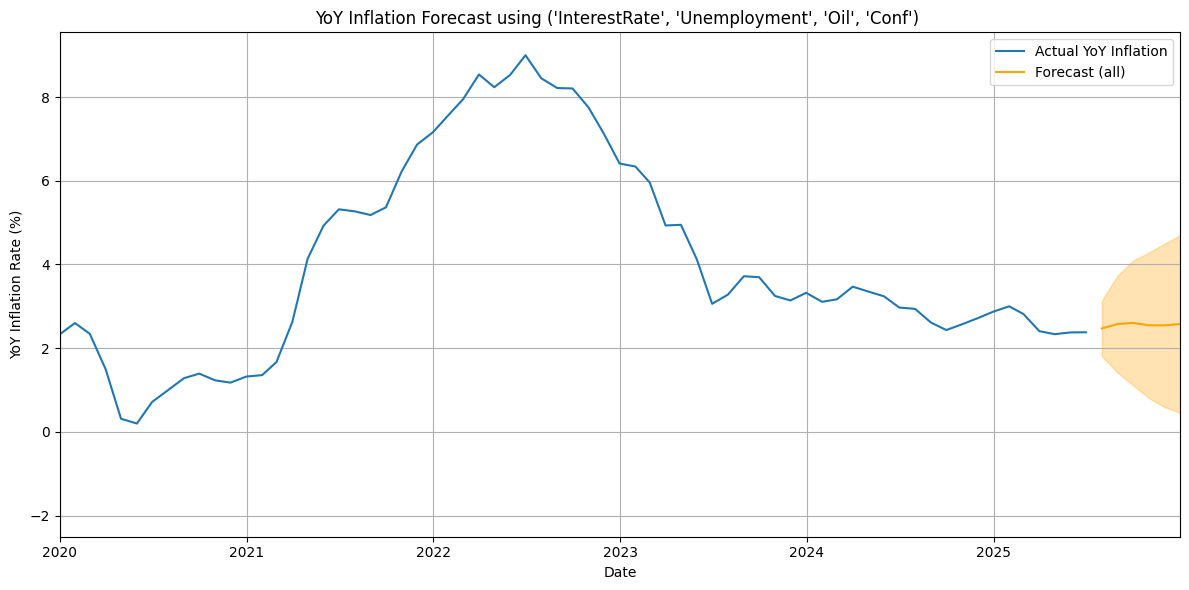

In [ ]:

plt.figure(figsize=(12,6))
plt.plot(data['YoY'], label='Actual YoY Inflation')
plt.plot(mean, label='Forecast ('+best_name+')', color='orange')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='orange', alpha=0.3)

# ⬇️ x축 범위 지정: 2020년부터 예측 마지막 날짜까지
plt.xlim(pd.to_datetime('2020-01-01'), mean.index[-1])

plt.title("YoY Inflation Forecast using ('InterestRate', 'Unemployment', 'Oil', 'Conf') ")
plt.xlabel("Date")
plt.ylabel("YoY Inflation Rate (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 신뢰구간 계산
conf_int = forecast.conf_int()

# 예측 결과 DataFrame 생성
forecast_df = pd.DataFrame({
    'Forecasted YoY CPI (%)': mean,
    'Lower CI (95%)': conf_int.iloc[:, 0],
    'Upper CI (95%)': conf_int.iloc[:, 1]
})

# 결과 출력
forecast_df


,Forecasted YoY CPI (%),Lower CI (95%),Upper CI (95%)
2025-07-31,2.470126,1.809569,3.130683
2025-08-31,2.576079,1.415482,3.736677
2025-09-30,2.601868,1.116472,4.087264
2025-10-31,2.546980,0.809896,4.284064
2025-11-30,2.543532,0.598567,4.488497
2025-12-31,2.575808,0.453250,4.698366
